# Packages 🗃

In [ ]:
install_packages <- function(){
  install.packages("caret")
  install.packages("rpart")
  install.packages("dplyr") 
  install.packages("randomForest")
  install.packages("gbm")
  install.packages("xgboost")
  install.packages("lightgbm")
  install.packages("MASS")
}
install_packages()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘data.table’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
global_imports <- function()
{
  require("caret")
  require("rpart")
  require("dplyr")
  require("randomForest")
  require("gbm")
  require("xgboost")
  require("lightgbm")
  require("MASS")
}
global_imports()

Loading required package: caret

Loading required package: lattice

Loading required package: ggplot2

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Loading required package: rpart

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: gbm

Loaded gbm 2.1.8

Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: lightgbm

Loading required pack

# Loading the data 📲

In [ ]:
db <- read.csv2("training.csv",sep=',',dec='.')

In [ ]:
Xdata = within(db, rm('claim_amount'))
ydata = db['claim_amount']

In [ ]:
sum(is.na(db))

[1] 234543

In [41]:
preprocess_X_data <- function (x_raw){
	# Data preprocessing function: given X_raw, clean the data for training or prediction.

	# Parameters
	# ----------
	# X_raw : Dataframe, with the columns described in the data dictionary.
	# 	Each row is a different contract. This data has not been processed.

	# Returns
	# -------
	# A cleaned / preprocessed version of the dataset

  # YOUR CODE HERE ------------------------------------------------------

  # picking features to remove
  #to_remove <- c("id_policy","year","drv_sex2","drv_age2","drv_age_lic2","vh_make_model","vh_weight","drv_age_lic1","vh_value","pol_no_claims_discount","pol_pay_freq","vh_type","vh_fuel")
  #X <- x_raw[names(x_raw)[-which(names(x_raw)%in%to_remove)]]
  X <-  dplyr::select( x_raw , -c("id_policy","year","drv_sex2","drv_age2","drv_age_lic2","vh_make_model","vh_weight","drv_age_lic1","vh_value","pol_no_claims_discount","pol_pay_freq","vh_fuel"))
  
  # dealing with missing data
  imp <- preProcess(X, method = "medianImpute")
  X_clean<- predict(imp, X)

  # dealing with categorial variables
    X_clean = X_clean %>% 
        mutate(pol_coverage = factor(pol_coverage)) %>%
        mutate(pol_usage=factor(ifelse(pol_usage=="AllTrips","Professional",as.character(pol_usage)))) %>% 
        mutate( drv_sex1 = factor(drv_sex1)) %>% 
        mutate( drv_drv2 = factor(drv_drv2)) %>%
        mutate( vh_type = factor(vh_type)) %>%
        mutate( pol_payd = factor(pol_payd))
       
   
  # dealing with continuous variables
  # drv_age1 is correlated to drv_age_lc1. also vh_weigth and vh_value. we have to choose onlyone of them

  # Binerizsation
  
  X_clean$drv_age1_factor <- cut(X_clean$drv_age1, c(19,30, 50,80,103), right = FALSE, include.lowest = TRUE)
  #X_clean <- dplyr::select(X_clean,-drv_age1)
  #cuts_drv_age = quantile(X_clean$drv_age1,seq(0, 1, 0.25))
  #X_clean$drv_age_factor = cut(X_clean$drv_age1, breaks=cuts_drv_age)

  #X_clean <- dplyr::select(X_clean,-drv_age1)
 
  remove(list = c("X","imp")) 
  # ---------------------------------------------------------------------
  return(X_clean)
}

In [103]:
X_clean<-preprocess_X_data(Xdata)
imp <- preProcess(ydata, method = "medianImpute")
y_clean<- predict(imp, ydata)

In [105]:
# Splitting data
set.seed(432)
trainIndex<- createDataPartition(1:nrow(X_clean), p = 0.8,list = FALSE) 
df = data.frame(y_clean, X_clean)
Q1 = quantile(df$claim_amount,0.25)
Q3 =quantile(df$claim_amount,0.75)
IQR = Q3-Q1
#df<- df[df$claim_amount<=Q3+1.5*IQR,]
df_train<-df[trainIndex,]
df_test<-df[-trainIndex,]
X_train<-X_clean[trainIndex,]
y_train<-y_clean[trainIndex]
X_test<-X_clean[-trainIndex,]
y_test<-y_clean[-trainIndex]
Y_test <-as.numeric(I(y_test>0))

# Frequency Models

In [106]:
# GLM Models
trained_model_frequency = glm(I(claim_amount>0) ~ .,
                                family = binomial(link = "logit"),
                                #offset= log(pol_duration),
                                data = df_train)                             

Warning message:
“glm.fit: algorithm did not converge”


In [109]:
ypred_glm<-predict(trained_model_frequency, newdata = X_test, type ="response" ) 
y_pred_glm <-sapply(ypred_glm,function(x) (ifelse(x>0.6,1,0)))
(MSE_glm=mean(y_pred_glm!=Y_test))

[1] 0.1073206

In [46]:
summary(trained_model_frequency)


Call:
glm(formula = I(claim_amount > 0) ~ ., family = binomial(link = "logit"), 
    data = df_train, offset = log(pol_duration))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8992  -0.5364  -0.4415  -0.3163   3.3285  

Coefficients: (4 not defined because of singularities)
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -9.671e+00  4.395e+01  -0.220   0.8259    
pol_coverageMed1        -4.220e-01  4.014e-02 -10.514  < 2e-16 ***
pol_coverageMed2        -3.687e-01  2.915e-02 -12.646  < 2e-16 ***
pol_coverageMin         -1.610e+00  6.830e-02 -23.575  < 2e-16 ***
pol_duration            -9.423e-02  1.245e-03 -75.680  < 2e-16 ***
pol_sit_duration        -8.127e-02  4.962e-03 -16.378  < 2e-16 ***
pol_paydNo               6.917e+00  4.395e+01   0.157   0.8750    
pol_paydYes              6.573e+00  4.395e+01   0.150   0.8811    
pol_usageProfessional    3.006e-01  3.332e-02   9.023  < 2e-16 ***
pol_usageRetired        -6.80

In [ ]:
trained_model_frequency_AIC <-stepAIC(trained_model_frequency,trace = FALSE)

In [110]:
# Decision Tree Model
dtree <- rpart(I(claim_amount>0)~.,
                method="class",
                data=df_train,
                control=rpart.control(cp= 0.05)
                ) 

ERROR: ignored

In [53]:
ypred_dtree<-predict(dtree, newdata = X_test,type= 'class')
(MSE_dtree=mean(as.numeric(ypred_dtree)!=Y_test))

[1] 0.8926794

In [ ]:
summary(dtree)

Call:
rpart(formula = I(claim_amount > 0) ~ ., data = df_train, method = "class", 
    control = rpart.control(cp = 0.05))
  n= 130920 

  CP nsplit rel error xerror xstd
1  0      0         1      0    0

Node number 1: 130920 observations
  predicted class=FALSE  expected loss=0.1055225  P(node) =1
    class counts: 117105 13815
   probabilities: 0.894 0.106 



In [54]:
# Gradient Boosting Machine
gbm <- gbm(I(claim_amount>0)~.,distribution="bernoulli", data=df_train)#shrinkage=0.001,n.trees= 5000, n.minobsinnode=1000,cv.folds = 1)

In [55]:
ypred_gbm<-predict(gbm, newdata = X_test,type = "response")
y_pred_gbm <-sapply(ypred_gbm,function(x) (ifelse(x>0.6,1,0)))
(MSE_gbm=mean(y_pred_gbm!=Y_test))

Using 100 trees...




[1] 0.1073206

# Severity Models

In [58]:
# lm MOdel
lm = lm(log(claim_amount) ~1,data = df_train,subset = claim_amount>0)

In [59]:
ypred_lm<-exp(predict(lm, newdata = X_test))
(MSE_bm=sqrt(mean((ypred_lm-y_test)^2)))

[1] 1072.875

In [ ]:
summary(lm)


Call:
lm(formula = log(claim_amount) ~ 1, data = df_train, subset = claim_amount > 
    0)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.3482  -0.6788   0.0778   0.7194   4.9762 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.436186   0.009844   653.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.157 on 13814 degrees of freedom


In [96]:
#glm
glm_s = glm(claim_amount ~.,family=Gamma,data = df_train,subset = claim_amount>0)
ypred_glm_s<-predict(glm_s, newdata = X_test,type = "response")
(MSE_glm_s=sqrt(mean((ypred_glm_s-y_test)^2)))

[1] 1343.409

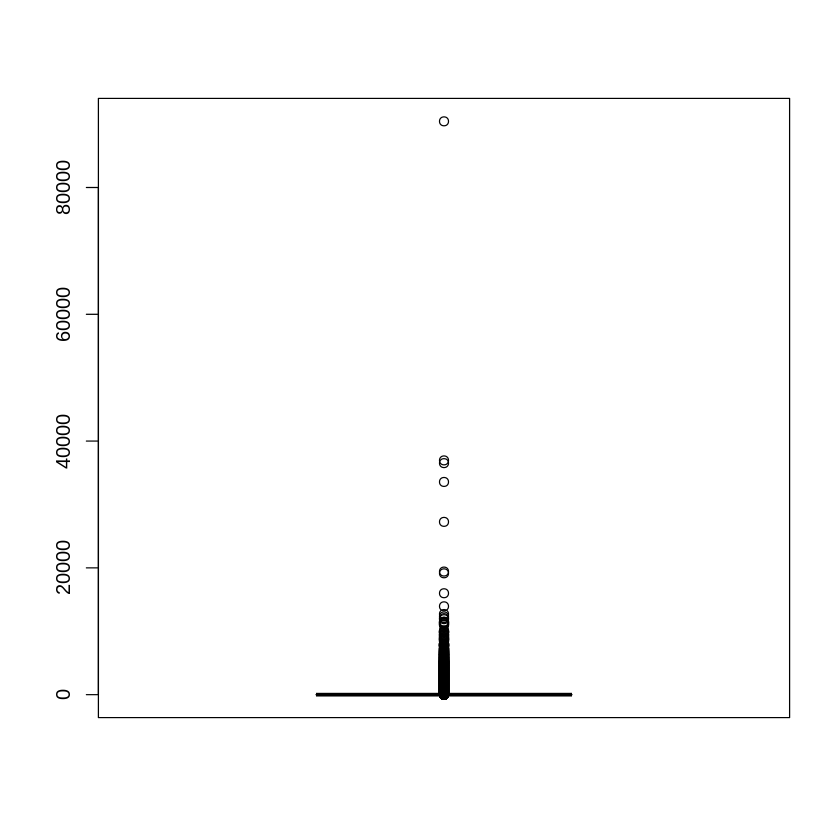

In [100]:
boxplot(y_train)

In [ ]:
# Decision Tree Model
dtree_s <- rpart(claim_amount~.,data=df_train,subset = claim_amount>0,parms=list(shrink=1),control=rpart.control(cp= 0.001, minsplit = 1000))
ypred_dtree_s<-predict(dtree_s, newdata = X_test)
(MSE_dtree_s=sqrt(mean((ypred_dtree_s-y_test)^2)))              

[1] 1367.301

In [ ]:
# gbm
df_train_s <- df_train[df_train$claim_amount>0,]
gbm_s <- gbm(log(claim_amount)~.,data=df_train_s,shrinkage=0.001,n.trees= 5000, n.minobsinnode=2000)
ypred_gbm_s<-exp(predict(gbm_s, newdata = X_test))
(MSE_gbm_s=sqrt(mean((ypred_gbm_s-y_test)^2)))   

Distribution not specified, assuming gaussian ...


Using 5000 trees...




[1] 1088.009

In [ ]:
dim(df)

[1] 163648     13

In [ ]:
# Xgboost
training_set<-df_train[df_train$claim_amount>0,]
folds = createFolds(training_set$claim_amount, k = 10)
cv = lapply(folds, function(x) {
  training_fold = training_set[-x, ]
  test_fold = training_set[x, ]
  classifier = xgboost(data = as.matrix(training_fold[-1]), label = training_fold$claim_amount, nrounds = 10)
  y_pred = exp(predict(classifier, newdata = as.matrix(test_fold[-1])))
  y_pred = (y_pred >= 0.5)
  cm = table(test_fold[, 1], y_pred)
  accuracy = (cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] + cm[1,2] + cm[2,1])
  return(accuracy)
  })
accuracy = mean(as.numeric(cv))

ERROR: ignored

In [ ]:
# lightgbm
train <-df_train[df_train$claim_amount>0,]
dtrain <- lgb.Dataset(train[-1], label = train$claim_amount)
model <- lgb.cv(
    params = list(
        objective = "regression"
        , metric = "mse"
    )
    , data = dtrain
)

ERROR: ignored

In [ ]:
str(df_train)

'data.frame':	130920 obs. of  13 variables:
 $ claim_amount     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ pol_coverage     : Factor w/ 4 levels "Max","Med1","Med2",..: 3 3 3 2 3 1 4 2 1 3 ...
 $ pol_duration     : int  5 6 8 2 8 4 6 29 6 2 ...
 $ pol_sit_duration : int  1 1 5 2 2 2 3 1 3 2 ...
 $ pol_payd         : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ pol_usage        : Factor w/ 4 levels "Professional",..: 4 4 4 2 2 4 4 4 4 4 ...
 $ drv_sex1         : Factor w/ 3 levels "","F","M": 3 3 2 2 2 2 3 3 2 3 ...
 $ drv_age1         : num  35 60 54 65 68 51 53 55 52 47 ...
 $ drv_drv2         : Factor w/ 3 levels "","No","Yes": 3 2 2 2 2 2 2 2 2 2 ...
 $ vh_age           : num  8 10 4 13 16 28 14 15 12 15 ...
 $ vh_speed         : num  174 174 149 200 196 173 189 188 200 159 ...
 $ population       : num  1270 1290 180 30 210 1760 810 120 50 870 ...
 $ town_surface_area: num  33.1 51.3 219.7 70.3 366.5 ...


## Define the training logic

In [ ]:
fit_model <- function (x_raw, y_raw){  # ! 
	# Model training function: given training data (X_raw, y_raw), train this pricing model.

	# Parameters
	# ----------
	# X_raw : Dataframe, with the columns described in the data dictionary.
	# 	Each row is a different contract. This data has not been processed.
	# y_raw : a array, with the value of the claims, in the same order as contracts in X_raw.
	# 	A one dimensional array, with values either 0 (most entries) or >0.

	# Returns
	# -------
	# self: (optional), this instance of the fitted model.

	
  # This function trains your models and returns the trained model.
  
  # YOUR CODE HERE ------------------------------------------------------

  X_clean = preprocess_X_data(x_raw)  # preprocess your data before fitting
  df = data.frame(y_raw, X_clean)
  rm(X_clean)
  # training frequency model (i.e. how often do claims occur)
  trained_model_frequency = glm(I(claim_amount>0) ~ .,family = binomial,data = df)                              

  # training a mean severity model (i.e. what is the average claim cost)
  trained_model_avg_severity = lm(log(claim_amount) ~ 1,
                                data = df,
                                offset =log(pol_duration),
                                subset = claim_amount>0)
  rm(df)
  
  # defining a list and putting the trained models in there
  trained_model = list(occurence = trained_model_frequency,
                       cost = trained_model_avg_severity)

  # ---------------------------------------------------------------------
  # The result trained_model is something that you will save in the next section
  
  return(trained_model)
}

In [ ]:
model = fit_model(Xdata, ydata)

## Saving your model

In [ ]:
save_model <- function(model){
  # Saves this trained model to a file.

  # This is used to save the model after training, so that it can be used for prediction later.

  # Do not touch this unless necessary (if you need specific features). If you do, do not
  #  forget to update the load_model method to be compatible.
	
  # The default is to save it in 'trained_model.RData', but change this if you 
  # are using a pacakge that requires a different saving format.
  # For h2o models see this discussion: https://discourse.aicrowd.com/t/any-tips-for-successfully-submitting-an-h2o-model/4194/

  save(model, file='trained_model.RData')
}

In [ ]:
load_model <- function(){ 
 # Load a saved trained model from the file `trained_model.RData`.
 # This is called by the server to evaluate your submission on hidden data.


 # Only modify this *if* you modified save_model.

  load('trained_model.RData')
  return(model)
}

In [ ]:
#model = load_model(MODEL_OUTPUT_PATH)

# Predicting the claims 💵

The second function, `predict_expected_claim`, takes your trained model and a dataframe of contracts, and outputs a prediction for the (expected) claim incurred by each contract. This expected claim can be seen as the probability of an accident multiplied by the cost of that accident.

This is the function used to compute the _RMSE_ leaderboard, where the model best able to predict claims wins.

In [ ]:
predict_expected_claim <- function(model, x_raw){
	# Model prediction function: predicts the average claim based on the pricing model.

	# This functions estimates the expected claim made by a contract (typically, as the product
	# of the probability of having a claim multiplied by the average cost of a claim if it occurs),
	# for each contract in the dataset X_raw.

	# This is the function used in the RMSE leaderboard, and hence the output should be as close
	# as possible to the expected cost of a contract.

	# Parameters
	# ----------
	# X_raw : Dataframe, with the columns described in the data dictionary.
	# 	Each row is a different contract. This data has not been processed.

	# Returns
	# -------
	# avg_claims: a one-dimensional array of the same length as X_raw, with one
	#     average claim per contract (in same order). These average claims must be POSITIVE (>0).


  # YOUR CODE HERE ------------------------------------------------------

  X_clean = preprocess_X_data(x_raw)  # preprocess your data before fitting

  expected_frequency = predict(model$occurence, newdata = X_clean, type= "response")
  expected_severity = exp(predict(model$cost, newdata = X_clean, type= "response"))

  expected_claims = expected_frequency * expected_severity
  rm(X_clean)

  return(expected_claims)  
}

In [ ]:
claims <- predict_expected_claim(model, Xdata)

# Pricing contracts 💰

The third and final function, `predict_premium`, takes your trained model and a dataframe of contracts, and outputs a _price_ for each of these contracts. **You are free to set this prices however you want!** These prices will then be used in competition with other models: contracts will choose the model offering the lowest price, and this model will have to pay the cost if an accident occurs.

This is the function used to compute the _profit_ leaderboard: your model will participate in many markets of size 10, populated by other participants' model, and we compute the average profit of your model over all the markets it participated in.

In [ ]:
predict_premium <- function(model, x_raw){
  # Model prediction function: predicts premiums based on the pricing model.

  # This function outputs the prices that will be offered to the contracts in X_raw.
  # premium will typically depend on the average claim predicted in 
  # predict_expected_claim, and will add some pricing strategy on top.

  # This is the function used in the average profit leaderboard. Prices output here will
  # be used in competition with other models, so feel free to use a pricing strategy.

  # Parameters
  # ----------
  # X_raw : Dataframe, with the columns described in the data dictionary.
  # 	Each row is a different contract. This data has not been processed.

  # Returns
  # -------
  # prices: a one-dimensional array of the same length as X_raw, with one
  #     price per contract (in same order). These prices must be POSITIVE (>0).


  # YOUR CODE HERE ------------------------------------------------------
  
  return(predict_expected_claim(model, x_raw) * 1.5) # boost prices by 50%
}


In [ ]:
prices <- predict_premium(model, Xdata)
as.matrix(head(prices))

1,64.030718
2,77.556130
3,8.474777
4,87.795035
5,10.669359
6,91.077175


#### Profit on training data

In order for your model to be considered in the profit competition, it needs to make nonnegative profit over its training set. You can check that your model satisfies this condition below:

In [ ]:
print(paste('Income:', sum(prices,na.rm = TRUE)))
print(paste('Losses:', sum(ydata)))

if (sum(prices,na.rm = TRUE) < sum(ydata)) {
    print('Your model loses money on the training data! It does not satisfy market rule 1: Non-negative training profit.')
    print('This model will be disqualified from the weekly profit leaderboard, but can be submitted for educational purposes to the RMSE leaderboard.')
} else {
    print('Your model passes the non-negative training profit test!')
}

[1] "Income: 29767749.8917614"
[1] "Losses: 26057988.08"
[1] "Your model passes the non-negative training profit test!"
